In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import cv2
from scipy.spatial import distance

Using TensorFlow backend.


#### Get data from the database

In [16]:
mask_path = "./Resources/Train/WithMask"
no_mask_path = "./Resources/faces"

In [27]:
image_mask = []
target_mask = []
for i in os.listdir(mask_path):
    pic = os.path.join(mask_path + "/", i)
    image_mask.append(pic)
    target_mask.append("mask")   

image_no_mask = []
target_no_mask = []
for i in os.listdir(no_mask_path):
    pic = os.path.join(no_mask_path + "/", i)
    image_no_mask.append(pic)
    target_no_mask.append("without_mask")

mask = pd.DataFrame()
mask["image"] = image_mask
mask["target"] = target_mask

no_mask = pd.DataFrame()
no_mask["image"] = image_no_mask
no_mask["target"] = target_no_mask

data = pd.concat([mask, no_mask], axis = 0, ignore_index = True)
data = shuffle(data)
data

,image,target
3417,./Resources/Train/WithMask/Augmented_605_55749...,mask
4092,./Resources/Train/WithMask/Augmented_731_12561...,mask
8594,./Resources/faces/1 (4122).jpg,without_mask
7568,./Resources/faces/1 (3217).jpg,without_mask
4677,./Resources/Train/WithMask/Augmented_843_71192...,mask
...,...,...
7018,./Resources/faces/1 (2733).jpg,without_mask
7826,./Resources/faces/1 (3446).jpg,without_mask
698,./Resources/Train/WithMask/899.png,mask
8040,./Resources/faces/1 (3635).jpg,without_mask


In [59]:
data.to_csv("./Resources/mask_no_mask.csv", encoding="utf-8")

In [26]:
def create_resultArray(path,label):
    result =[]
    target =[]
    #Append iamge and labels to the list form the directory
    for i in os.listdir(path):
        pic = os.path.join(path + "/", i)
        result.append(pic)
        target.append(label)   
    return result , target

mask_list , mask_target = create_resultArray(mask_path , "with_mask")
no_mask_list, no_mask_target = create_resultArray(no_mask_path , "without_mask")

mask = pd.DataFrame()
mask["image"] = mask_list
mask["target"] = mask_target

no_mask = pd.DataFrame()
no_mask["image"] = no_mask_list
no_mask["target"] = no_mask_target

data1 = pd.concat([mask, no_mask], axis = 0, ignore_index = True)
data1 = shuffle(data)
data1

,image,target
546,./Resources/Train/WithMask/519.png,mask
9267,./Resources/faces/1 (4718).jpg,without_mask
2979,./Resources/Train/WithMask/Augmented_519_42417...,mask
9778,./Resources/faces/1 (5169).jpg,without_mask
7316,./Resources/faces/1 (2999).jpg,without_mask
...,...,...
7566,./Resources/faces/1 (3215).jpg,without_mask
5372,./Resources/faces/1 (13).jpeg,without_mask
2643,./Resources/Train/WithMask/Augmented_458_47642...,mask
6701,./Resources/faces/1 (2453).jpg,without_mask


#### Building MobileNetV2 transfer learning model.¶

C:\Users\ubc\anaconda3\envs\maclearnpy\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='target', ylabel='count'>

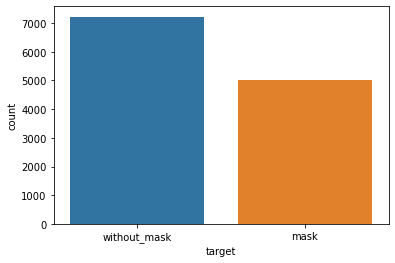

In [23]:
sns.countplot(data["target"])

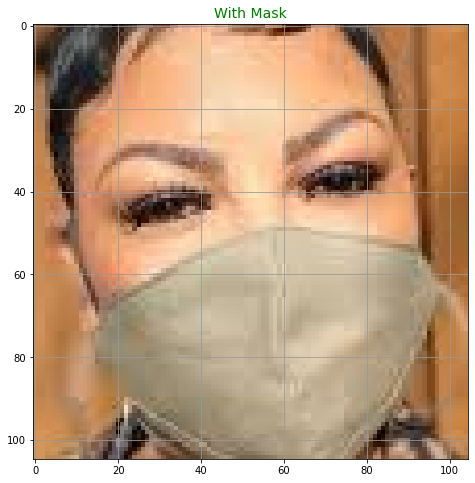

In [30]:
plt.figure(figsize=(12,8))

img = load_img(mask["image"][10])
plt.imshow(img)
plt.title("With Mask", color = "green", size = 14)
plt.grid(color='#999999', linestyle='-')
plt.show()

#### Prepare for data augmentation: 
    - ImageDataGenerator accepts the original data, randomly transforms it, and returns only the new, transformed data.

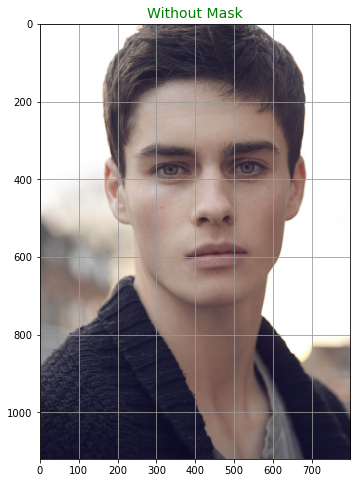

In [31]:
plt.figure(figsize=(12,8))

img = load_img(no_mask["image"][750])
plt.imshow(img)
plt.title("Without Mask", color = "green", size = 14)
plt.grid(color='#999999', linestyle='-')
plt.show()


In [32]:
train = data.iloc[0:10000, ]
val = data.iloc[10001:11001, ]
test = data.iloc[11002:, ]

In [33]:
print("Train Seti:","\n",train["target"].value_counts(),"\n""Validation Seti: ","\n", val["target"].value_counts(), "\n"
      "Test Seti: ", "\n",test["target"].value_counts())

Train Seti: 
 without_mask    5872
mask            4128
Name: target, dtype: int64 
Validation Seti:  
 without_mask    606
mask            394
Name: target, dtype: int64 
Test Seti:  
 without_mask    741
mask            476
Name: target, dtype: int64


In [34]:

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = "nearest")

train_generator = train_datagen.flow_from_dataframe(dataframe = train,
                                                    x_col = "image",
                                                    y_col = "target",
                                                    target_size = (128, 128),
                                                    batch_size = 32,
                                                    class_mode = "binary")

val_datagen = ImageDataGenerator(rescale = 1./255)

val_generator = val_datagen.flow_from_dataframe(dataframe = val,
                                                x_col = "image",
                                                y_col = "target",
                                                target_size = (128, 128),
                                                batch_size = 32,
                                                class_mode = "binary")
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_dataframe(dataframe = test,
                                                  x_col = "image",
                                                  y_col = "target",
                                                  target_size = (128, 128),
                                                  class_mode = "binary",
                                                  batch_size = 32)

Found 10000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 1217 validated image filenames belonging to 2 classes.


In [35]:
from keras import layers
from keras import models
from keras import optimizers
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

for layer in vgg19.layers:
    layer.trainable = False
    
model = models.Sequential()
model.add(vgg19)
model.add(layers.Flatten())
model.add(layers.Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 8193      
Total params: 20,032,577
Trainable params: 8,193
Non-trainable params: 20,024,384
_________________________________________________________________


compile and train our face mask detector network:

In [36]:
model.compile(loss = "binary_crossentropy",
             optimizer = optimizers.RMSprop(lr = 1e-4),
             metrics = ["acc"])

#### Evaluate the resulting model on the test set:

In [37]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator)//32,
                    epochs=60,
                    validation_data=val_generator,
                    validation_steps=len(val_generator)//32)


Epoch 1/60
9/9 [==============================] - 20s 2s/step - loss: 0.6426 - acc: 0.6007 - val_loss: 0.5340 - val_acc: 0.7500
Epoch 2/60
9/9 [==============================] - 23s 3s/step - loss: 0.5883 - acc: 0.7188 - val_loss: 0.6687 - val_acc: 0.5938
Epoch 3/60
9/9 [==============================] - 30s 3s/step - loss: 0.5427 - acc: 0.7917 - val_loss: 0.5530 - val_acc: 0.8125
Epoch 4/60
9/9 [==============================] - 36s 4s/step - loss: 0.5375 - acc: 0.7812 - val_loss: 0.5140 - val_acc: 0.7812
Epoch 5/60
9/9 [==============================] - 37s 4s/step - loss: 0.5233 - acc: 0.8090 - val_loss: 0.4845 - val_acc: 0.8125
Epoch 6/60
9/9 [==============================] - 37s 4s/step - loss: 0.4952 - acc: 0.8368 - val_loss: 0.5008 - val_acc: 0.7812
Epoch 7/60
9/9 [==============================] - 38s 4s/step - loss: 0.4666 - acc: 0.8299 - val_loss: 0.3530 - val_acc: 0.8750
Epoch 8/60
9/9 [==============================] - 37s 4s/step - loss: 0.4531 - acc: 0.8542 - val_loss: 0

C:\Users\ubc\anaconda3\envs\maclearnpy\lib\site-packages\PIL\Image.py:952: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


9/9 [==============================] - 46s 5s/step - loss: 0.3109 - acc: 0.9062 - val_loss: 0.2668 - val_acc: 0.9375
Epoch 22/60
9/9 [==============================] - 43s 5s/step - loss: 0.2879 - acc: 0.9410 - val_loss: 0.3549 - val_acc: 0.8125
Epoch 23/60
9/9 [==============================] - 48s 5s/step - loss: 0.2948 - acc: 0.9167 - val_loss: 0.1623 - val_acc: 1.0000
Epoch 24/60
9/9 [==============================] - 44s 5s/step - loss: 0.3025 - acc: 0.9132 - val_loss: 0.2696 - val_acc: 0.9375
Epoch 25/60
9/9 [==============================] - 43s 5s/step - loss: 0.2986 - acc: 0.9201 - val_loss: 0.1694 - val_acc: 0.9688
Epoch 26/60
9/9 [==============================] - 47s 5s/step - loss: 0.2970 - acc: 0.8889 - val_loss: 0.2439 - val_acc: 0.8750
Epoch 27/60
9/9 [==============================] - 51s 6s/step - loss: 0.2799 - acc: 0.9097 - val_loss: 0.2673 - val_acc: 0.8750
Epoch 28/60
9/9 [==============================] - 43s 5s/step - loss: 0.2781 - acc: 0.8993 - val_loss: 0.160

<AxesSubplot:>

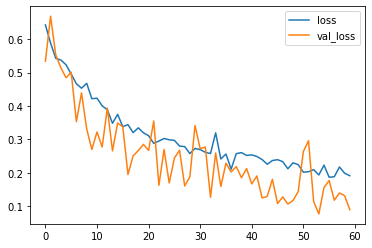

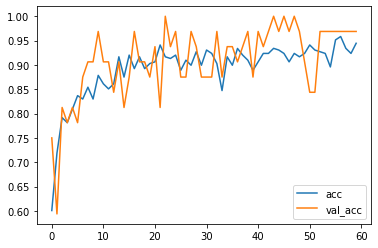

In [39]:
hist_df = pd.DataFrame(history.history)
hist_df.loc[:,['loss','val_loss']].plot()
hist_df.loc[:,['acc','val_acc']].plot()

In [40]:
test_loss, test_acc = model.evaluate(test_generator, steps = 9)
print("Test ACC: ", round(test_acc, 2))

9/9 [==============================] - 16s 2s/step
Test ACC:  0.94


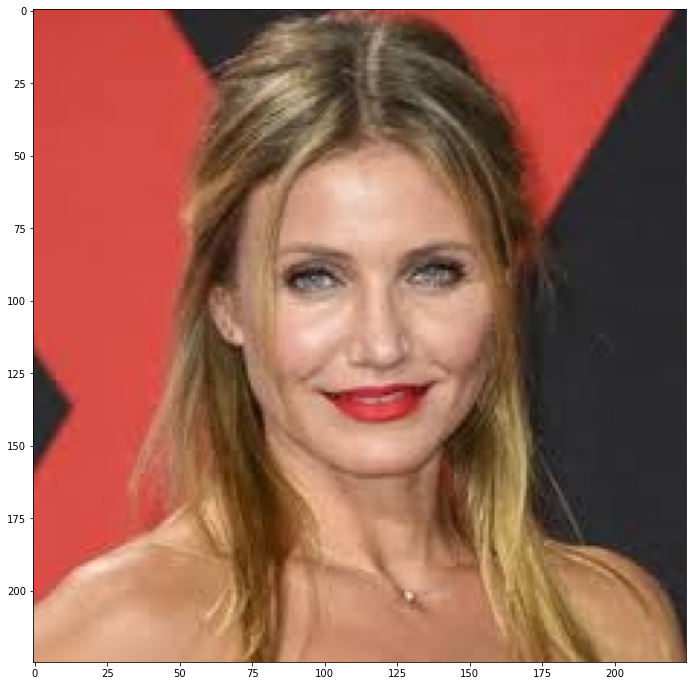

In [50]:
# test for realtime prediction

face_model = cv2.CascadeClassifier('./Resources/haarcascade_frontalface_default.xml')

img = cv2.imread('./Resources/Test/74.jpg')

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4)


out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
# for (x,y,w,h) in faces:
#     cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)
plt.figure(figsize=(12,12))
plt.imshow(out_img)

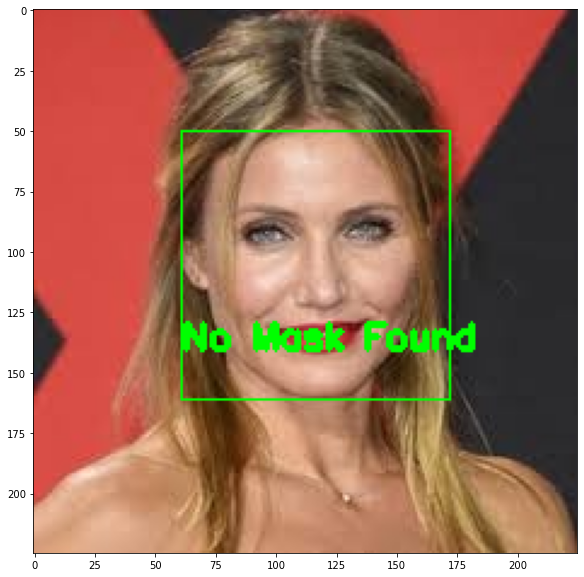

In [52]:
mask_label = {0:'Mask Found',1:'No Mask Found'}
color_label = {0:(0,255,0),1:(255,0,0)}
MIN_DISTANCE = 0

#check for no. of faces in the image
# if more than one face found,
if len(faces)>=1:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    
    # For every face found,   
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(128,128))
        crop = np.reshape(crop,[1,128,128,3])/255.0        
        mask_result = model.predict(crop)
        
        cv2.putText(new_img,mask_label[round(mask_result[0][0])],(x, y+90), cv2.FONT_HERSHEY_SIMPLEX,0.5,color_label[label[i]],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),color_label[label[i]],1)
        
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No image")

In [57]:
model.save('./Saved_Model/keras_model.hdf5')